In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from bs4 import BeautifulSoup
import requests
from collections import Counter
from IPython.core.display import HTML
%matplotlib inline

In [2]:
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [3]:
import datetime as dt
import warnings
warnings.filterwarnings("ignore")

In [4]:
url = "https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_daily_reports/"

In [5]:
soup = BeautifulSoup(requests.get(url).text)

In [6]:
timeline_csvs = soup.select("a[href$='.csv']")
last_date = dt.datetime.strptime(timeline_csvs[-1]['href'].split("/")[-1][:-4],"%m-%d-%Y")
HTML("<h2 align='center'>Start Date: "+timeline_csvs[0]['href'].split("/")[-1][:-4]+"</h2>"\
     "<h2 align='center'>End Date: "+timeline_csvs[-1]['href'].split("/")[-1][:-4]+"</h2>")

In [7]:
def update_countries(df):
    misspelled_countries = ["Taiwan","China","Russia","Bahamas","Gambia","Hong Kong","Iran","Moldova","Ireland","Taipei"]
    
    df.loc[(df['Country_Region']=="Macao SAR") | (df['Country_Region']=="Macau"),"Country_Region"] = "Macao"
    df.loc[(df['Country_Region']=="Republic of Korea") | (df['Country_Region']=="Korea, South"),"Country_Region"] = "South Korea"
    df.loc[(df['Country_Region']=="West Bank and Gaza") | (df['Country_Region'].str.contains("Palestin")),"Country_Region"] = "Palestinian Territory"
    df.loc[df['Country_Region']=="UK","Country_Region"] = "United Kingdom"
    df.loc[df['Country_Region']=="US","Country_Region"] = "United States"
    df.loc[df['Country_Region']=="Viet Nam","Country_Region"] = "Vietnam"
    df.loc[df['Country_Region']=="Burma","Country_Region"] = "Myanmar"
    df.loc[df['Country_Region']=="Cape Verde","Country_Region"] = "Cabo Verde"
    df.loc[df['Country_Region'].str.contains("Czech"),"Country_Region"] = "Czechia"
    df.loc[df['Country_Region'].str.startswith("Congo"),"Country_Region"] = "Congo"
    
    for country in range(len(misspelled_countries)):
        df.loc[df['Country_Region'].str.contains(misspelled_countries[country]),"Country_Region"] = misspelled_countries[country]
    
    return df


In [8]:
df = pd.DataFrame()
country_counts = Counter()
for each in range(len(timeline_csvs)):
    csv_date = timeline_csvs[each]['href'].split("/")[-1][:-4]
    time_slice = pd.read_html(url + csv_date + ".csv")[0]
    time_slice.columns = time_slice.columns.str.replace("/","_")
    time_slice = update_countries(time_slice)
    for country in time_slice['Country_Region'].unique():
        country_counts[country] += 1
    if len(time_slice.columns) != 13:
        if len(time_slice.columns) == 9:
            del time_slice['Latitude']
            del time_slice['Longitude']
        del time_slice['Unnamed: 0']
        del time_slice['Last Update']
        time_slice['Active'] = time_slice['Confirmed'] - time_slice['Deaths'] - time_slice['Recovered']
        time_slice['Date'] = dt.datetime.strptime(csv_date,"%m-%d-%Y")
    else:
        del time_slice['Unnamed: 0']
        del time_slice['Lat']
        del time_slice['Long_']
        del time_slice['Last_Update']
        del time_slice['Combined_Key']
        del time_slice['FIPS']
        del time_slice['Admin2']
        time_slice['Date'] = dt.datetime.strptime(csv_date,"%m-%d-%Y")
    df = df.append(time_slice)

In [9]:
confirmed_df = df.groupby(["Country_Region","Date"])['Confirmed'].sum().unstack().sort_values(last_date, ascending = False)
death_df = df.groupby(["Country_Region","Date"])['Deaths'].sum().unstack().sort_values(last_date, ascending = False).loc[[x for x in confirmed_df.nlargest(10,last_date).replace(0,np.NaN).index]]#.nlargest(10,last_date)

confirmed_df.to_excel("confirmed_cases.xlsx")
death_df.to_excel("fatalities.xlsx")

confirmed_df = confirmed_df.nlargest(10,last_date).replace(0,np.NaN)
totals = df.groupby("Date").sum().reset_index(drop=True)

In [10]:
def hover(hover_color="#ffff99"):
    return dict(selector="tr:hover",
                props=[("background-color", "%s" % hover_color)])
styles = [
    hover(),
    dict(selector="th", props=[("font-size", "150%"),
                               ("text-align", "center")]),
    dict(selector="td", props=[("text-align", "center")]),
    dict(selector="caption", props=[("caption-side", "bottom")]),
    dict(selector="table",props=[("margin-left","auto"),
                                 ("margin-right","auto")])
]

In [11]:
aggs = pd.DataFrame(totals.iloc[-1,:-1]).T
aggs['Fatality Rate'] = aggs['Deaths'] / aggs['Confirmed'] *100
aggs.style.set_table_styles(styles)\
.set_caption("Hover to highlight.")\
.format({"Confirmed":"{:,.0f}",
    "Deaths":"{:,.0f}",
    "Recovered":"{:,.0f}",
    "Active":"{:,.0f}",
    "Fatality Rate":"{:.2f}%"})\
.set_table_attributes('border="1" align="center" class="dataframe table table-hover table-bordered"')\
.hide_index()


Confirmed,Deaths,Recovered,Fatality Rate
"1,197,405","64,606","246,152",5.40%


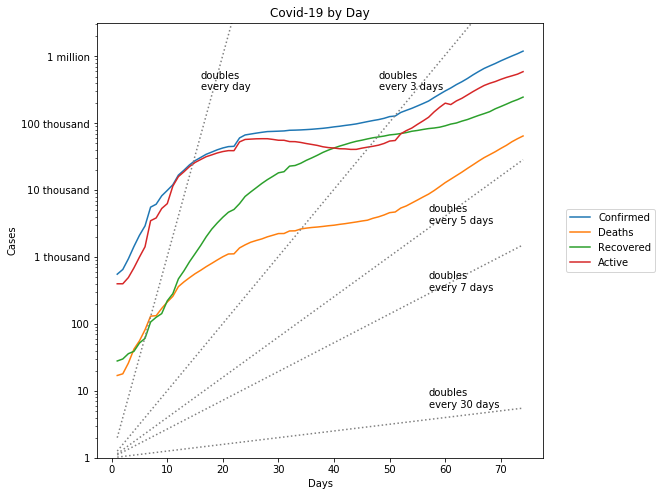

In [12]:
fig,ax = plt.subplots(figsize=(8,8))

totals.index = totals.index + 1
ax.plot(totals.index,totals)
for y in [1,3,5,7,30]:
    ax.plot(np.arange(1,max(country_counts.values())+1),
             [2**(x * (1/y)) for x in np.arange(1,max(country_counts.values())+1)],
             linestyle=':',
             c="gray")

ax.set_ylim([1,10**6.5])
ax.set_yscale("log")
ax.annotate("doubles\nevery day",(16,10**5.5))
ax.annotate("doubles\nevery 3 days",(48,10**5.5))
ax.annotate("doubles\nevery 5 days",(57,10**3.5))
ax.annotate("doubles\nevery 7 days",(57,10**2.5))
ax.annotate("doubles\nevery 30 days",(57,10**0.75))
ax.set_ylabel("Cases")
ax.set_xlabel("Days")
ax.legend(labels=totals.columns,bbox_to_anchor=(1.04,0.5), loc="center left")
ax.set_yticklabels(["0","1","10","100","1 thousand","10 thousand","100 thousand","1 million","10 million","100 million","1 billion"])
ax.set_title("Covid-19 by Day")

# plt.savefig("covid.png",bbox_inches="tight")
plt.show()

In [13]:
rates_df = df.groupby("Country_Region").sum()
rates_df['Fatality Rate'] = rates_df['Deaths']/rates_df['Confirmed']*100


html_table = rates_df.loc[rates_df['Confirmed']>1000].nlargest(10,"Fatality Rate")


html_table = "<h1 align='center'>Highest Fatality Rates for Countries with over 1,000 Cases</h1>" + \
             html_table.style.set_table_styles(styles)\
                       .set_caption("Hover to highlight.")\
                       .format({"Confirmed":"{:,.0f}",
                                "Deaths":"{:,.0f}",
                                "Recovered":"{:,.0f}",
                                "Active":"{:,.0f}",
                                "Fatality Rate":"{:.2f}%"})\
                       .set_table_attributes('border="1" align="center" class="dataframe table table-hover table-bordered"')\
                       .render()
HTML(html_table)

,Confirmed,Deaths,Recovered,Active,Fatality Rate
Country_Region,,,,,
Italy,"1,681,364","173,642","222,003","1,285,717",10.33%
San Marino,"4,449",436,176,"3,837",9.80%
Indonesia,"19,516","1,688","1,071","16,757",8.65%
Spain,"1,204,082","97,443","217,386","889,253",8.09%
Algeria,"9,083",703,868,"7,512",7.74%
Iraq,"9,567",725,"2,351","6,491",7.58%
Congo,"1,355",100,28,"1,227",7.38%
United Kingdom,"310,930","22,336","2,935","285,657",7.18%
Netherlands,"163,033","11,499","1,848","149,686",7.05%


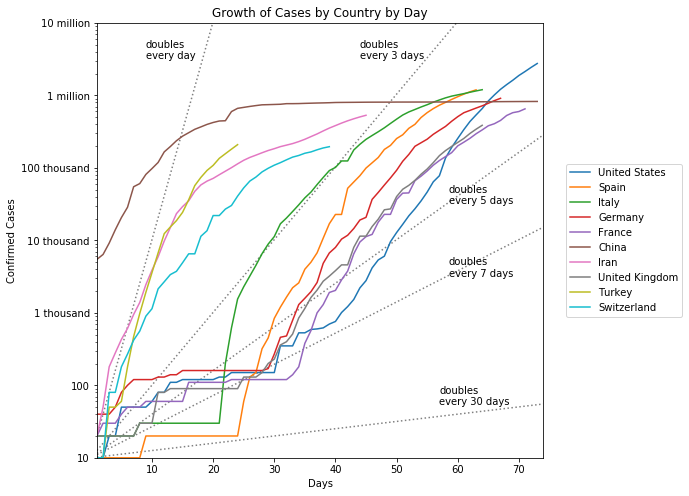

In [14]:
fig,ax = plt.subplots(figsize=(8,8))
for y in [1,3,5,7,30]:
    plt.plot(np.arange(1,max(country_counts.values())+1),
             [2**(x * (1/y)) for x in np.arange(1,max(country_counts.values())+1)],
             linestyle=':',
             c="gray")
for x in range(len(confirmed_df)):
    country_df = confirmed_df.iloc[x,:-1].dropna().reset_index(drop=True)
    country_df.index = country_df.index + 1
    country_df.plot(ax=ax)

ax.set_yscale("log")
ax.set_ylim([1,10**6])
ax.annotate("doubles\nevery day",(9,10**5.5))
ax.annotate("doubles\nevery 3 days",(44,10**5.5))
ax.annotate("doubles\nevery 5 days",(58.5,10**3.5))
ax.annotate("doubles\nevery 7 days",(58.5,10**2.5))
ax.annotate("doubles\nevery 30 days",(57,10**0.73))
ax.set_ylabel("Confirmed Cases")
ax.set_xlabel("Days")
ax.set_yticklabels(["1","10","100","1 thousand","10 thousand","100 thousand","1 million","10 million","100 million","1 billion"])
plt.title("Growth of Cases by Country by Day")
ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left")
plt.savefig("covid_confirmed.png",bbox_inches="tight")
plt.show()

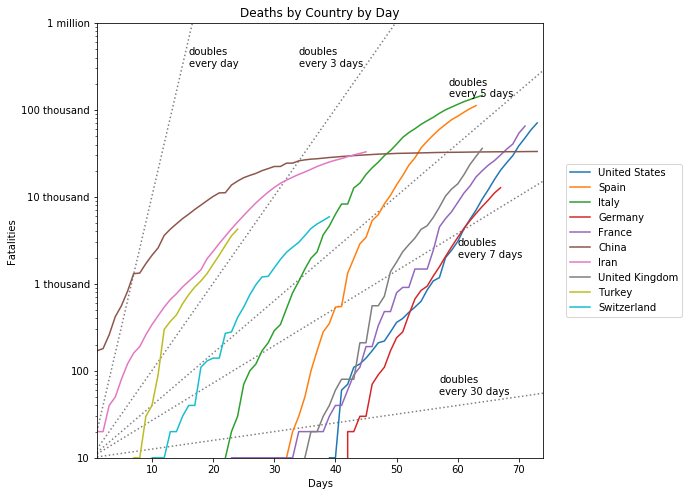

In [15]:
fig,ax = plt.subplots(figsize=(8,8))
for y in [1,3,5,7,30]:
    plt.plot(np.arange(1,max(country_counts.values())+1),
             [2**(x * (1/y)) for x in np.arange(1,max(country_counts.values())+1)],
             linestyle=':',
             c="gray")
for x in range(len(death_df)):
    country_df = death_df.iloc[x,:-1].dropna().reset_index(drop=True)
    country_df.index = country_df.index + 1
    country_df.plot(ax=ax)

ax.set_yscale("log")
ax.set_ylim([1,10**5])
ax.annotate("doubles\nevery day",(16,10**4.5))
ax.annotate("doubles\nevery 3 days",(34,10**4.5))
ax.annotate("doubles\nevery 5 days",(58.5,10**4.15))
ax.annotate("doubles\nevery 7 days",(60,10**2.3))
ax.annotate("doubles\nevery 30 days",(57,10**0.73))
ax.set_ylabel("Fatalities")
ax.set_xlabel("Days")
ax.set_yticklabels(["1","10","100","1 thousand","10 thousand","100 thousand","1 million","10 million","100 million","1 billion"])
plt.title("Deaths by Country by Day")
ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left")
plt.savefig("covid_dead.png",bbox_inches="tight")
plt.show()

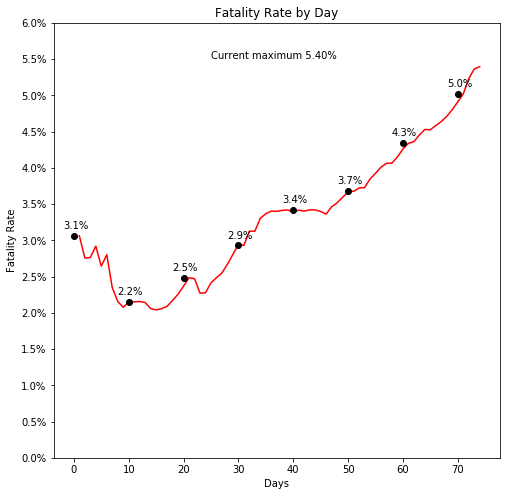

In [26]:
totals['Fatality Rate'] = totals['Deaths'] / totals['Confirmed']

fig,ax = plt.subplots(figsize=(8,8))
ax.plot(totals['Fatality Rate'],c="red")

ten_day_vals = range(0, max(totals.index) + 1 ,10)
corresponding_day_vals = [totals["Fatality Rate"].iloc[x] for x in list(ten_day_vals)]

for x,y in zip(ten_day_vals,corresponding_day_vals):
    ax.plot(x,y,marker="o",c="black")
    ax.annotate("{:.1f}%".format(y*100),(x-2,y+0.001))

ax.set_yticks(np.arange(0,totals['Fatality Rate'].max()+0.01,0.005))
ax.set_yticklabels(list(map('{:.1f}%'.format,np.arange(0,totals['Fatality Rate'].max()+0.01,0.005)*100)))

plt.title("Fatality Rate by Day")
plt.ylabel("Fatality Rate")
plt.xlabel("Days")
ax.annotate("Current maximum {:.2f}%".format(totals['Fatality Rate'].max()*100), (25,0.055))
plt.savefig("Fatality Rate by Day.png")
plt.show()